This notebook shows a final preprocessing steps to dataset.

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive',  force_remount = True)

Mounted at /content/drive


In [4]:
path_to_file = "./data/commit_size_over_10000.csv"
df = pd.read_csv(path_to_file)

In [5]:
actual_descriptor = 'commit'
specific_id = actual_descriptor+'_id'
specific_count = actual_descriptor + '_count'

In [6]:
if "repo_id" in df.columns:
  df.rename({"repo_id":"project_id"},inplace=True)

In [7]:
df.head()

,commit_id,author_id,commiter_id,project_id,created_at,repo_size
0,977642044,342219,342219,9402294,2018-04-15 09:08:11 UTC,171738
1,977648333,3284059,3284059,8163431,2018-04-15 00:36:16 UTC,281170
2,977650139,11199553,11199553,31257538,2018-04-15 08:56:52 UTC,33872
3,977656802,1424627,1424627,4594981,2018-04-15 09:41:47 UTC,90863
4,977665565,66505,66505,20052,2018-04-15 09:58:21 UTC,1482098


In [8]:
# remove UTC and format date
df['created_at'] = df['created_at'].astype('str')
df['created_at'] = df.created_at.apply(lambda x: x.replace('UTC',''))
df.created_at = pd.to_datetime( df.created_at.to_list(), yearfirst = True, format="%Y-%m-%d %H:%M:%S" )

In [9]:
# filter repos with short life
long_live_repos = []
for repo_id in tqdm(df.project_id.unique()):
  pr_id = repo_id
  df_project = df.loc[df.project_id == pr_id].copy()
  df_project.sort_values(by='created_at', inplace= True)
  if (df_project.iloc[-1].created_at - df_project.iloc[0].created_at).days >= 3 * 365:
     long_live_repos.append(df_project)

df = pd.concat(long_live_repos)

100%|██████████| 6318/6318 [02:37<00:00, 40.23it/s]


In [10]:
# count number of commits per each repository
out = df.groupby(['project_id']).count().reset_index().rename(columns={specific_id:specific_count}) 

# choose repos of reasonable size
threshold_for_commits = 300
r = out[['project_id',specific_count]][out[specific_count] > threshold_for_commits]

# join with main table
df = df.merge(r, how="inner", on='project_id', suffixes=('_left', '_right') )

In [11]:
df.head()

,commit_id,author_id,commiter_id,project_id,created_at,repo_size,commit_count
0,104994502,342219,342219,9402294,2014-04-17 19:39:23,171738,3930
1,385931077,342219,342219,9402294,2014-04-17 21:39:07,171738,3930
2,104994494,342219,342219,9402294,2014-04-18 13:34:59,171738,3930
3,104994509,342219,342219,9402294,2014-04-18 14:04:21,171738,3930
4,104994515,342219,342219,9402294,2014-04-18 14:46:57,171738,3930


In [12]:
print(f'remaining repositories which have more then {threshold_for_commits} commits : {len(df.project_id.unique())}')
print(f'number of unique commits count in all repositoreis      : {len(df[specific_count].unique())}')

remaining repositories which have more then 300 commits : 2127
number of unique commits count in all repositoreis      : 1735


In [13]:
# work with repos
threshold1 = np.datetime64('2021-01-01')

s2 = set(df.project_id[ df.created_at <  threshold1].unique())
s3 = set(df.project_id[ df.created_at >  threshold1].unique())

repos_with_time_threshold = s2.difference(s3)
print(f'number of repositories which have commits before {threshold1} but not after it: {len(repos_with_time_threshold)}')

number of repositories which have commits before 2021-01-01 but not after it: 2127


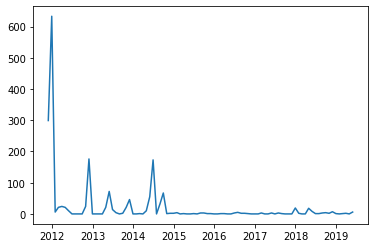

In [14]:
# show activity in specific repo
def commits_in_time(df, pr_id):
  df_project = df.loc[df.project_id == pr_id].copy()
  # df_project = df_project.created_at
  df_project.sort_values(by='created_at', inplace= True)
  out = df_project.groupby(pd.Grouper(key='created_at', freq='M')).count()[specific_id]

  y = out.to_list()
  x = out.index.to_list()

  pyplot.plot(x,y)

commits_in_time(df,pr_id = 500724)

In [15]:
# find repos where activity ceased gradually and stayed that way (have longer tails)

valid_repos = []
segment_size_months = 12
max_mean_percent_per_month = 5
last_n_days_silence = 30 * segment_size_months

for repo_id in tqdm(repos_with_time_threshold):

  df_project = df.loc[df.project_id == repo_id].copy()
  out = df_project.groupby(pd.Grouper(key='created_at', freq='M')).count()[specific_id].reset_index().rename(columns={specific_id:specific_count})
  max_commit_cnt = out[specific_count].max()

  last_date = out.iloc[-1].created_at
  # get days from last commit
  out['timedelta_last_commit'] = out['created_at'].apply(lambda x: (last_date - x).days)
  # choose commits which are newer then 365 days before last commit 
  last_year_commits = out[out.timedelta_last_commit < last_n_days_silence]
  # find if any month last year was commit count bigger then 5% of max commit counts ever
  still_active_repo = last_year_commits[last_year_commits[specific_count] > max_commit_cnt * (max_mean_percent_per_month/100)].any()

  if still_active_repo[specific_count]:
    # repository not dead yet
    continue
  else:
    # repository is dead
    valid_repos.append(repo_id)

100%|██████████| 2127/2127 [01:09<00:00, 30.45it/s]


In [16]:
# strip long tails from repos which are long inactive

df_stripped_right_agregated = []
for repo_id in tqdm(valid_repos):
  df_project = df.loc[df.project_id == repo_id].copy()
  out = df_project.groupby(pd.Grouper(key='created_at', freq='M')).count()["commit_id"].reset_index().rename(columns={"commit_id":"commit_count"})
  max_commit_cnt = out[specific_count].max()
  out[f'mean_months'] = out.rolling(segment_size_months).mean()

  idx_end = None
  for idx,row in out[::-1].iterrows():
    if row.mean_months > max_commit_cnt * (max_mean_percent_per_month/100) :
      idx_end = idx
      break
  # this is last date which stays in dataset, older dates then this will be gone
  last_date = out.iloc[idx_end].created_at

  out = out.loc[out.created_at <= last_date]
  out['project_id'] = [repo_id] * len(out)
  df_stripped_right_agregated.append(out)

  df_project = df_project.loc[df_project.created_at <= last_date]

  7%|▋         | 25/382 [00:00<00:10, 34.08it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 382/382 [00:11<00:00, 31.90it/s]


In [20]:
df_stripped_right_agregated = pd.concat(df_stripped_right_agregated)
df_stripped_right_agregated.drop(columns=['mean_months'],inplace=True)

Here comes section where all of the data will be preprocessed and joined into one table.

In [21]:
def clean_naming_and_date_in_df(data):
  df = data.copy()
  df.repo_id = df.repo_id.astype(int)

  if "repo_id" in df.columns:
    df.rename(columns={"repo_id":"project_id"},inplace=True)

  df['created_at'] = df['created_at'].astype('str')
  df['created_at'] = df.created_at.apply(lambda x: x.replace('UTC',''))
  df.created_at = pd.to_datetime( df.created_at.to_list(), yearfirst = True, format="%Y-%m-%d %H:%M:%S" )

  return df


def get_other_tables_agregated(df_commits_agregated, df_not_agregated,  data_descriptor: str):
  df_stripped_right_agregated = []

  specific_id = data_descriptor+'_id'
  specific_count = data_descriptor + '_count'
  for repo_id in tqdm(df_commits_agregated.project_id.unique()):
    relevant_months = len(df_commits_agregated[df_commits_agregated.project_id == repo_id])
    df_project = df_not_agregated.loc[df_not_agregated.project_id == repo_id].copy()
    # agregate by months
    out = df_project.groupby(pd.Grouper(key='created_at', freq='M')).count()[specific_id].reset_index().rename(columns={specific_id:specific_count})
    out = out.iloc[:relevant_months]
    out['project_id'] = [repo_id] * len(out)

    df_stripped_right_agregated.append(out)

  return pd.concat(df_stripped_right_agregated)

def add_records_where_missing(df_commits_agregated, df_other_agregated, data_descriptor):

  added_column = data_descriptor+"_count"

  all_repos = df_commits_agregated.project_id.unique()
  repos = df_other_agregated.project_id.unique()
  missing_repos = set(all_repos).difference(set(repos))

  data = []
  for repo_id in missing_repos:
    new_created_at = df_commits_agregated[df_commits_agregated.project_id == repo_id].created_at.to_list()
    new_project_id = df_commits_agregated[df_commits_agregated.project_id == repo_id].project_id.to_list()
    missing_atr = [0] * len(new_project_id)
    data.append( pd.DataFrame({'created_at':new_created_at,'project_id': new_project_id, added_column: missing_atr  }) )

  return pd.concat([df_other_agregated, pd.concat(data) ])


In [22]:
path_to_file = './data'

df_other = pd.read_csv(os.path.join(path_to_file,'issue_size_over_10000.csv'))
df_issue_a = get_other_tables_agregated(df_stripped_right_agregated,clean_naming_and_date_in_df(df_other),'issue' )

df_other = pd.read_csv(os.path.join(path_to_file,'watcher_size_over_10000.csv')) 
df_watcher_a = get_other_tables_agregated(df_stripped_right_agregated,clean_naming_and_date_in_df(df_other),'user' )

100%|██████████| 382/382 [00:05<00:00, 74.41it/s]


In [23]:

df_issue_a = add_records_where_missing(df_stripped_right_agregated,df_issue_a,'issue')
df_watcher_a = add_records_where_missing(df_stripped_right_agregated,df_watcher_a,'user')

In [24]:
df_all = df_stripped_right_agregated.merge(df_issue_a, how="left", on=['project_id','created_at'])
df_all = df_all.merge(df_watcher_a, how="left", on=['project_id','created_at'])

In [25]:
df_all.fillna(0, inplace = True)

In [28]:
# store preprocessed dataset

# df_all.to_csv("./data/data_for_training.csv", index=False)

